# Análise Técnica – Case iFood

Este notebook responde tecnicamente às questões apresentadas no case de Data Analytics do iFood. Todos os dados foram tratados com foco em reprodutibilidade, clareza e organização.

## 1. Impacto da Campanha de Cupons (Teste A/B)

Nesta seção, analisamos o impacto da campanha de cupons sobre a retenção de usuários.

- **1a)** Indicadores e análise de impacto
- **1b)** Análise de viabilidade financeira
- **1c)** Propostas de novos testes A/B

## 2. Segmentação de Usuários

Aqui propomos segmentações relevantes para o teste A/B, com base em comportamento de consumo.

- **2a)** Definição dos segmentos
- **2b)** Critérios utilizados
- **2c)** Análise por segmento

## 3. Consolidação dos Resultados

Nesta última parte, centralizamos as métricas-chave produzidas, sem interpretações de negócio. Para isso, mantemos apenas os números objetivos resultantes das análises anteriores.

In [1]:
# Instalação de pacotes necessários
!pip install --quiet pandas google-cloud-bigquery pandas-gbq scikit-learn seaborn plotly
!pip install --quiet scipy statsmodels matplotlib numpy

# Autenticação no Google Cloud
from google.colab import auth
auth.authenticate_user()

# Imports principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Estatística e modelagem
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# BigQuery
from google.cloud import bigquery
import pandas_gbq

# Configurações
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Ambiente configurado com sucesso!")

# Configuração do BigQuery
project_id = "294185590533"
dataset_id = "ifood"
client = bigquery.Client(project=project_id)

print(f"Conectado ao projeto: {project_id}")
print(f"Dataset: {dataset_id}")

def executar_query_bigquery(query, descricao="Query"):
    """
    Executa uma query no BigQuery e retorna um DataFrame

    Args:
        query (str): Query SQL para executar
        descricao (str): Descrição da query para logging

    Returns:
        pd.DataFrame: Resultado da query
    """
    print(f"Executando: {descricao}...")
    try:
        df = client.query(query).to_dataframe()
        print(f"Sucesso: {len(df):,} registros retornados")
        return df
    except Exception as e:
        print(f"Erro na execução: {str(e)}")
        raise


def calcular_estatisticas_descritivas(df, grupo_col, metricas):
    """
    Calcula estatísticas descritivas por grupo

    Args:
        df (pd.DataFrame): DataFrame com os dados
        grupo_col (str): Nome da coluna de agrupamento
        metricas (list): Lista de colunas para calcular estatísticas

    Returns:
        pd.DataFrame: Estatísticas por grupo
    """
    stats_df = df.groupby(grupo_col)[metricas].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)

    return stats_df


def realizar_teste_estatistico(grupo1, grupo2, tipo_teste='ttest'):
    """
    Realiza teste estatístico entre dois grupos

    Args:
        grupo1, grupo2: Arrays com os dados dos grupos
        tipo_teste (str): Tipo de teste ('ttest', 'mannwhitney', 'chi2')

    Returns:
        dict: Resultado do teste com estatística e p-valor
    """
    if tipo_teste == 'ttest':
        stat, p_value = ttest_ind(grupo1, grupo2)
        teste_nome = "T-test"
    elif tipo_teste == 'mannwhitney':
        stat, p_value = mannwhitneyu(grupo1, grupo2, alternative='two-sided')
        teste_nome = "Mann-Whitney U"

    # Interpretação do p-valor
    if p_value < 0.001:
        significancia = "Altamente significativo (p < 0.001)"
    elif p_value < 0.01:
        significancia = "Muito significativo (p < 0.01)"
    elif p_value < 0.05:
        significancia = "Significativo (p < 0.05)"
    else:
        significancia = "Não significativo (p >= 0.05)"

    return {
        'teste': teste_nome,
        'estatistica': stat,
        'p_valor': p_value,
        'significancia': significancia
    }


def calcular_effect_size(grupo1, grupo2):
    """
    Calcula o Cohen's d (effect size) entre dois grupos

    Args:
        grupo1, grupo2: Arrays com os dados dos grupos

    Returns:
        float: Cohen's d
    """
    mean1, mean2 = np.mean(grupo1), np.mean(grupo2)
    std1, std2 = np.std(grupo1, ddof=1), np.std(grupo2, ddof=1)
    n1, n2 = len(grupo1), len(grupo2)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    # Cohen's d
    cohens_d = (mean1 - mean2) / pooled_std

    return cohens_d


def interpretar_effect_size(d):
    """
    Interpreta o Cohen's d

    Args:
        d (float): Cohen's d

    Returns:
        str: Interpretação do effect size
    """
    d_abs = abs(d)
    if d_abs < 0.2:
        return "Efeito pequeno"
    elif d_abs < 0.5:
        return "Efeito pequeno a médio"
    elif d_abs < 0.8:
        return "Efeito médio a grande"
    else:
        return "Efeito grande"

print("Funções auxiliares definidas com sucesso!")

# Carregamento dos dados do teste A/B
query_ab_test = f"""
SELECT
    customer_id,
    is_target,
    CASE
        WHEN is_target = 'target' THEN 1
        ELSE 0
    END as grupo_teste
FROM `{project_id}.{dataset_id}.ab_test_ref_raw`
"""

df_ab_test = executar_query_bigquery(query_ab_test, "Dados do teste A/B")

print("\nDistribuição dos grupos:")
print(df_ab_test['is_target'].value_counts())
print(f"\nTotal de usuários no experimento: {len(df_ab_test):,}")

Ambiente configurado com sucesso!
Conectado ao projeto: 294185590533
Dataset: ifood
Funções auxiliares definidas com sucesso!
Executando: Dados do teste A/B...
Sucesso: 806,467 registros retornados

Distribuição dos grupos:
is_target
target     445925
control    360542
Name: count, dtype: int64

Total de usuários no experimento: 806,467


In [2]:
# Carregamento dos dados de consumidores
query_consumers = f"""
SELECT
    customer_id,
    language,
    created_at,
    active,
    customer_name,
    customer_phone_area
FROM `{project_id}.{dataset_id}.consumers_raw`
"""

df_consumers = executar_query_bigquery(query_consumers, "Dados de consumidores")

print(f"\nTotal de consumidores: {len(df_consumers):,}")
print(f"Consumidores ativos: {df_consumers['active'].sum():,}")

Executando: Dados de consumidores...
Sucesso: 806,156 registros retornados

Total de consumidores: 806,156
Consumidores ativos: 804,561


In [3]:
# Criação do dataset unificado com métricas de pedidos
# Utilizamos agregação no BigQuery para otimizar performance
query_pedidos_agregados = f"""
WITH pedidos_por_usuario AS (
    SELECT
        customer_id,
        COUNT(*) as total_pedidos,
        SUM(order_total_amount) as receita_total,
        AVG(order_total_amount) as ticket_medio,
        MIN(order_created_at) as primeiro_pedido,
        MAX(order_created_at) as ultimo_pedido,
        COUNT(DISTINCT merchant_id) as restaurantes_unicos,
        COUNT(DISTINCT DATE(order_created_at)) as dias_com_pedidos,

        -- Métricas temporais
        DATE_DIFF(MAX(order_created_at), MIN(order_created_at), DAY) as periodo_atividade_dias,

        -- Pedidos por período (para análise de retenção)
        COUNT(CASE WHEN order_created_at >= '2018-12-01' AND order_created_at < '2019-01-01' THEN 1 END) as pedidos_dezembro,
        COUNT(CASE WHEN order_created_at >= '2019-01-01' AND order_created_at < '2019-02-01' THEN 1 END) as pedidos_janeiro,

        -- Receita por período
        SUM(CASE WHEN order_created_at >= '2018-12-01' AND order_created_at < '2019-01-01' THEN order_total_amount ELSE 0 END) as receita_dezembro,
        SUM(CASE WHEN order_created_at >= '2019-01-01' AND order_created_at < '2019-02-01' THEN order_total_amount ELSE 0 END) as receita_janeiro

    FROM `{project_id}.{dataset_id}.orders_raw`
    GROUP BY customer_id
),

usuarios_experimento AS (
    SELECT
        ab.customer_id,
        ab.is_target, -- CORRIGIDO: Usando diretamente a coluna is_target

        -- Dados do consumidor
        c.language,
        c.created_at as data_cadastro,
        c.active,
        c.customer_phone_area,

        -- Métricas de pedidos
        COALESCE(p.total_pedidos, 0) as total_pedidos,
        COALESCE(p.receita_total, 0) as receita_total,
        COALESCE(p.ticket_medio, 0) as ticket_medio,
        COALESCE(p.restaurantes_unicos, 0) as restaurantes_unicos,
        COALESCE(p.dias_com_pedidos, 0) as dias_com_pedidos,
        COALESCE(p.periodo_atividade_dias, 0) as periodo_atividade_dias,

        -- Métricas por período
        COALESCE(p.pedidos_dezembro, 0) as pedidos_dezembro,
        COALESCE(p.pedidos_janeiro, 0) as pedidos_janeiro,
        COALESCE(p.receita_dezembro, 0) as receita_dezembro,
        COALESCE(p.receita_janeiro, 0) as receita_janeiro,

        -- Flags de atividade
        CASE WHEN COALESCE(p.pedidos_dezembro, 0) > 0 THEN 1 ELSE 0 END as ativo_dezembro,
        CASE WHEN COALESCE(p.pedidos_janeiro, 0) > 0 THEN 1 ELSE 0 END as ativo_janeiro,
        CASE WHEN COALESCE(p.pedidos_dezembro, 0) > 0 AND COALESCE(p.pedidos_janeiro, 0) > 0 THEN 1 ELSE 0 END as retido_janeiro,

        -- Frequência
        CASE
            WHEN COALESCE(p.periodo_atividade_dias, 0) > 0
            THEN COALESCE(p.total_pedidos, 0) / COALESCE(p.periodo_atividade_dias, 1)
            ELSE 0
        END as frequencia_pedidos_por_dia

    FROM (
        SELECT customer_id, is_target
        FROM `{project_id}.{dataset_id}.ab_test_ref_raw`
        WHERE customer_id IS NOT NULL
    ) ab

    LEFT JOIN (
        SELECT customer_id, language, created_at, active, customer_phone_area
        FROM `{project_id}.{dataset_id}.consumers_raw`
        WHERE customer_id IS NOT NULL
    ) c ON ab.customer_id = c.customer_id

    LEFT JOIN pedidos_por_usuario p ON ab.customer_id = p.customer_id
)

SELECT * FROM usuarios_experimento
ORDER BY receita_total DESC

"""

df_unified = executar_query_bigquery(query_pedidos_agregados, "Dataset unificado")

print(f"\nDataset unificado criado com {len(df_unified):,} usuários")
print(f"Colunas disponíveis: {len(df_unified.columns)}")

# Visualização das primeiras linhas
print("\nPrimeiras 5 linhas do dataset:")
display(df_unified.head())

Executando: Dataset unificado...
Sucesso: 806,466 registros retornados

Dataset unificado criado com 806,466 usuários
Colunas disponíveis: 20

Primeiras 5 linhas do dataset:


,customer_id,is_target,language,data_cadastro,active,customer_phone_area,total_pedidos,receita_total,ticket_medio,restaurantes_unicos,dias_com_pedidos,periodo_atividade_dias,pedidos_dezembro,pedidos_janeiro,receita_dezembro,receita_janeiro,ativo_dezembro,ativo_janeiro,retido_janeiro,frequencia_pedidos_por_dia
0,361e229dbc1b985e1aacb3e70384782a05d77ad6db53e7...,control,pt-br,2018-04-06T05:06:31.818Z,True,56,4,280677.80,70169.45,1,2,30,2,2,140338.90,140338.90,1,1,1,0.13
1,5fce0e4cd3113305baa43c5a3b61ff196efd13c04d008b...,target,pt-br,2018-04-06T04:04:56.642Z,True,38,4,37302.60,9325.65,3,1,0,0,4,0.00,37302.60,0,1,0,0.00
2,bd053524e63dbf144c198c9840154d2e73b7e6001dbedf...,control,pt-br,2018-04-06T03:43:37.376Z,True,90,2,28084.00,14042.00,1,1,0,0,2,0.00,28084.00,0,1,0,0.00
3,dbae4016df6932dc7a0c8ba1b50fe79b670483d4dbc1a4...,control,pt-br,2018-04-06T04:16:12.375Z,True,85,4,22193.80,5548.45,1,2,30,2,2,11096.90,11096.90,1,1,1,0.13
4,0d980c1ea8b0bdfb3bd02e4be896eac32ff3b9e2658975...,target,pt-br,2018-01-12T14:01:55.863Z,True,35,1,14959.60,14959.60,1,1,0,0,1,0.00,14959.60,0,1,0,0.00


In [4]:
# Definição e cálculo dos KPIs principais
print("=" * 60)
print("ANÁLISE ESTATÍSTICA DO TESTE A/B")
print("=" * 60)

# Separação dos grupos
grupo_controle = df_unified[df_unified['is_target'] == 'control']
grupo_teste = df_unified[df_unified['is_target'] == 'target']

print(f"\nTamanho dos grupos:")
print(f"Grupo Controle: {len(grupo_controle):,} usuários")
print(f"Grupo Teste: {len(grupo_teste):,} usuários")

# Verificação do balanceamento
proporcao_teste = len(grupo_teste) / len(df_unified)
print(f"\nBalanceamento: {proporcao_teste:.1%} teste vs {1-proporcao_teste:.1%} controle")

# KPIs principais por grupo
metricas_principais = [
    'total_pedidos', 'receita_total', 'ticket_medio',
    'pedidos_janeiro', 'receita_janeiro', 'retido_janeiro'
]

print("\n" + "=" * 50)
print("KPIs PRINCIPAIS POR GRUPO")
print("=" * 50)

kpis_resumo = df_unified.groupby('is_target')[metricas_principais].agg([
    'count', 'mean', 'median', 'std'
]).round(2)

display(kpis_resumo)

ANÁLISE ESTATÍSTICA DO TESTE A/B

Tamanho dos grupos:
Grupo Controle: 360,542 usuários
Grupo Teste: 445,924 usuários

Balanceamento: 55.3% teste vs 44.7% controle

KPIs PRINCIPAIS POR GRUPO


total_pedidos                  receita_total                       \
                  count mean median  std         count   mean median    std   
is_target                                                                     
control          360542 4.23   2.00 5.47        360542 202.67 101.60 565.59   
target           445924 4.79   3.00 5.87        445924 228.76 120.00 342.86   

          ticket_medio                     pedidos_janeiro                   \
                 count  mean median    std           count mean median  std   
is_target                                                                     
control         360542 48.01  40.82 126.27          360542 2.80   1.00 3.59   
target          445924 47.83  41.00  43.14          445924 3.18   2.00 3.86   

          receita_janeiro                      retido_janeiro                   
                    count   mean median    std          count mean median  std  
is_target                                                                       
control            360542 134.33  66.70 315.99         360542 0.67   1.00 0.47  
target             445924 151.89  80.20 229.97         445924 0.70   1.00 0.46

In [5]:
# Testes de significância estatística
print("\n" + "=" * 50)
print("TESTES DE SIGNIFICÂNCIA ESTATÍSTICA")
print("=" * 50)

resultados_testes = {}

# Métricas para teste t (variáveis contínuas)
metricas_continuas = ['total_pedidos', 'receita_total', 'ticket_medio', 'pedidos_janeiro', 'receita_janeiro']

for metrica in metricas_continuas:
    # Dados dos grupos (removendo zeros para algumas métricas quando apropriado)
    dados_controle = grupo_controle[metrica]
    dados_teste = grupo_teste[metrica]

    # Teste de normalidade (Shapiro-Wilk em amostra)
    amostra_controle = dados_controle.sample(min(5000, len(dados_controle)), random_state=42)
    amostra_teste = dados_teste.sample(min(5000, len(dados_teste)), random_state=42)

    _, p_norm_controle = stats.shapiro(amostra_controle)
    _, p_norm_teste = stats.shapiro(amostra_teste)

    # Escolha do teste baseado na normalidade
    if p_norm_controle > 0.05 and p_norm_teste > 0.05:
        resultado = realizar_teste_estatistico(dados_controle, dados_teste, 'ttest')
    else:
        resultado = realizar_teste_estatistico(dados_controle, dados_teste, 'mannwhitney')

    # Cálculo do effect size
    effect_size = calcular_effect_size(dados_teste, dados_controle)  # teste - controle
    interpretacao_effect = interpretar_effect_size(effect_size)

    # Diferença percentual
    media_controle = dados_controle.mean()
    media_teste = dados_teste.mean()
    diff_percentual = ((media_teste - media_controle) / media_controle * 100) if media_controle > 0 else 0

    resultados_testes[metrica] = {
        'media_controle': media_controle,
        'media_teste': media_teste,
        'diferenca_percentual': diff_percentual,
        'p_valor': resultado['p_valor'],
        'significancia': resultado['significancia'],
        'effect_size': effect_size,
        'interpretacao_effect': interpretacao_effect,
        'teste_usado': resultado['teste']
    }

    print(f"\n{metrica.upper()}:")
    print(f"  Controle: {media_controle:.2f}")
    print(f"  Teste: {media_teste:.2f}")
    print(f"  Diferença: {diff_percentual:+.1f}%")
    print(f"  {resultado['teste']}: p = {resultado['p_valor']:.4f}")
    print(f"  {resultado['significancia']}")
    print(f"  Effect Size (Cohen's d): {effect_size:.3f} ({interpretacao_effect})")

# Teste específico para taxa de retenção (proporção)
print(f"\nTAXA DE RETENÇÃO (Janeiro):")
retencao_controle = grupo_controle['retido_janeiro'].sum()
total_controle = len(grupo_controle)
retencao_teste = grupo_teste['retido_janeiro'].sum()
total_teste = len(grupo_teste)

taxa_retencao_controle = retencao_controle / total_controle
taxa_retencao_teste = retencao_teste / total_teste

# Teste qui-quadrado para proporções
tabela_contingencia = np.array([
    [retencao_controle, total_controle - retencao_controle],
    [retencao_teste, total_teste - retencao_teste]
])

chi2, p_chi2, dof, expected = chi2_contingency(tabela_contingencia)

print(f"  Controle: {taxa_retencao_controle:.1%} ({retencao_controle:,}/{total_controle:,})")
print(f"  Teste: {taxa_retencao_teste:.1%} ({retencao_teste:,}/{total_teste:,})")
print(f"  Diferença: {(taxa_retencao_teste - taxa_retencao_controle)*100:+.1f} pontos percentuais")
print(f"  Chi-quadrado: p = {p_chi2:.4f}")
if p_chi2 < 0.05:
    print(f"  Diferença estatisticamente significativa")
else:
    print(f"  Diferença não significativa")


TESTES DE SIGNIFICÂNCIA ESTATÍSTICA

TOTAL_PEDIDOS:
  Controle: 4.23
  Teste: 4.79
  Diferença: +13.2%
  Mann-Whitney U: p = 0.0000
  Altamente significativo (p < 0.001)
  Effect Size (Cohen's d): 0.098 (Efeito pequeno)

RECEITA_TOTAL:
  Controle: 202.67
  Teste: 228.76
  Diferença: +12.9%
  Mann-Whitney U: p = 0.0000
  Altamente significativo (p < 0.001)
  Effect Size (Cohen's d): 0.057 (Efeito pequeno)

TICKET_MEDIO:
  Controle: 48.01
  Teste: 47.83
  Diferença: -0.4%
  Mann-Whitney U: p = 0.0000
  Altamente significativo (p < 0.001)
  Effect Size (Cohen's d): -0.002 (Efeito pequeno)

PEDIDOS_JANEIRO:
  Controle: 2.80
  Teste: 3.18
  Diferença: +13.3%
  Mann-Whitney U: p = 0.0000
  Altamente significativo (p < 0.001)
  Effect Size (Cohen's d): 0.100 (Efeito pequeno)

RECEITA_JANEIRO:
  Controle: 134.33
  Teste: 151.89
  Diferença: +13.1%
  Mann-Whitney U: p = 0.0000
  Altamente significativo (p < 0.001)
  Effect Size (Cohen's d): 0.065 (Efeito pequeno)

TAXA DE RETENÇÃO (Janeiro):
 

In [6]:
print("=" * 60)
print("ANÁLISE DE VIABILIDADE FINANCEIRA")
print("=" * 60)

# Premissas financeiras (baseadas em benchmarks do setor)
PREMISSAS = {
    'desconto_cupom_pct': 15,  # 15% de desconto médio
    'taxa_uso_cupom': 0.60,    # 60% dos usuários do grupo teste usaram o cupom
    'margem_contribuicao': 0.25,  # 25% de margem de contribuição
    'custo_operacional_cupom': 2.00,  # R$ 2,00 de custo operacional por cupom
    'taxa_desconto_clv': 0.10,  # 10% a.a. para cálculo de CLV
    'periodo_clv_meses': 12   # Período de 12 meses para CLV
}

print("PREMISSAS ADOTADAS:")
for chave, valor in PREMISSAS.items():
    if 'pct' in chave or 'taxa' in chave:
        print(f"  {chave}: {valor:.0%}" if valor < 1 else f"  {chave}: {valor:.0f}%")
    else:
        print(f"  {chave}: {valor}")

# Cálculos financeiros
print("\n" + "=" * 40)
print("=" * 40)

# Receita incremental
receita_incremental_total = grupo_teste['receita_janeiro'].sum() - grupo_controle['receita_janeiro'].sum()
receita_incremental_por_usuario = receita_incremental_total / len(grupo_teste)

# Custo dos cupons
ticket_medio_grupo_teste = grupo_teste[grupo_teste['receita_janeiro'] > 0]['receita_janeiro'].mean()
custo_desconto_por_cupom = ticket_medio_grupo_teste * (PREMISSAS['desconto_cupom_pct'] / 100)
usuarios_que_usaram_cupom = len(grupo_teste) * PREMISSAS['taxa_uso_cupom']
custo_total_descontos = usuarios_que_usaram_cupom * custo_desconto_por_cupom
custo_total_operacional = len(grupo_teste) * PREMISSAS['custo_operacional_cupom']
custo_total_campanha = custo_total_descontos + custo_total_operacional

# ROI
margem_incremental = receita_incremental_total * PREMISSAS['margem_contribuicao']
roi = (margem_incremental - custo_total_campanha) / custo_total_campanha

print(f"\nRECEITA:")
print(f"  Receita incremental total: R$ {receita_incremental_total:,.2f}")
print(f"  Receita incremental por usuário: R$ {receita_incremental_por_usuario:,.2f}")
print(f"  Margem incremental (25%): R$ {margem_incremental:,.2f}")

print(f"\nCUSTOS:")
print(f"  Ticket médio grupo teste: R$ {ticket_medio_grupo_teste:,.2f}")
print(f"  Custo desconto por cupom: R$ {custo_desconto_por_cupom:,.2f}")
print(f"  Usuários que usaram cupom: {usuarios_que_usaram_cupom:,.0f}")
print(f"  Custo total descontos: R$ {custo_total_descontos:,.2f}")
print(f"  Custo operacional: R$ {custo_total_operacional:,.2f}")
print(f"  Custo total da campanha: R$ {custo_total_campanha:,.2f}")

print(f"\nRESULTADO:")
if roi > 0:
    print(f"  ✅ Campanha VIÁVEL financeiramente")
else:
    print(f"  ❌ Campanha NÃO VIÁVEL financeiramente")

ANÁLISE DE VIABILIDADE FINANCEIRA
PREMISSAS ADOTADAS:
  desconto_cupom_pct: 15%
  taxa_uso_cupom: 60%
  margem_contribuicao: 0.25
  custo_operacional_cupom: 2.0
  taxa_desconto_clv: 10%
  periodo_clv_meses: 12


RECEITA:
  Receita incremental total: R$ 19,297,782.96
  Receita incremental por usuário: R$ 43.28
  Margem incremental (25%): R$ 4,824,445.74

CUSTOS:
  Ticket médio grupo teste: R$ 151.89
  Custo desconto por cupom: R$ 22.78
  Usuários que usaram cupom: 267,554
  Custo total descontos: R$ 6,095,903.83
  Custo operacional: R$ 891,848.00
  Custo total da campanha: R$ 6,987,751.83

RESULTADO:
  ❌ Campanha NÃO VIÁVEL financeiramente


In [7]:
# Análise de cenários
print("\n" + "=" * 40)
print("ANÁLISE DE CENÁRIOS")
print("=" * 40)

def calcular_roi_cenario(taxa_uso, desconto_pct, margem_pct):
    """Calcula ROI para um cenário específico"""
    custo_desconto = len(grupo_teste) * taxa_uso * ticket_medio_grupo_teste * (desconto_pct / 100)
    custo_total = custo_desconto + custo_total_operacional
    margem = receita_incremental_total * (margem_pct / 100)
    return (margem - custo_total) / custo_total

cenarios = {
    'Conservador': {'taxa_uso': 0.40, 'desconto': 20, 'margem': 20},
    'Realista': {'taxa_uso': 0.60, 'desconto': 15, 'margem': 25},
    'Otimista': {'taxa_uso': 0.80, 'desconto': 10, 'margem': 30}
}

print("-" * 50)

for nome, params in cenarios.items():
    roi_cenario = calcular_roi_cenario(
        params['taxa_uso'],
        params['desconto'],
        params['margem']
    )
    print(f"{nome:<12} {params['taxa_uso']:<10.0%} {params['desconto']:<10.0f}% {params['margem']:<8.0f}% {roi_cenario:<8.1%}")

# Payback period
print(f"\n" + "=" * 40)
print("PAYBACK PERIOD")
print("=" * 40)

if margem_incremental > custo_total_campanha:
    # Assumindo que o benefício se mantém mensalmente
    beneficio_mensal = (margem_incremental - custo_total_campanha) / 2  # 2 meses de dados
    payback_meses = custo_total_campanha / beneficio_mensal if beneficio_mensal > 0 else float('inf')
    print(f"Payback period: {payback_meses:.1f} meses")
else:
    print("Payback não alcançado no período analisado")


ANÁLISE DE CENÁRIOS
--------------------------------------------------
Conservador  40%        20        % 20      % -38.8%  
Realista     60%        15        % 25      % -31.0%  
Otimista     80%        10        % 30      % -8.3%   

PAYBACK PERIOD
Payback não alcançado no período analisado


In [8]:
print("=" * 60)
print("SEGMENTAÇÃO RFM (RECENCY, FREQUENCY, MONETARY)")
print("=" * 60)

# Preparação dos dados para RFM
df_rfm = df_unified[df_unified['total_pedidos'] > 0].copy()

print(f"Usuários com pedidos para análise RFM: {len(df_rfm):,}")

# Cálculo das métricas RFM
data_referencia = pd.to_datetime('2019-01-31')

# Recency: baseado em atividade em janeiro
df_rfm['recency_score'] = df_rfm['ativo_janeiro'].apply(lambda x: 5 if x == 1 else 1)

# Frequency e Monetary
df_rfm['frequency'] = df_rfm['total_pedidos']
df_rfm['monetary'] = df_rfm['receita_total']

# Criação dos scores
df_rfm['R_score'] = df_rfm['recency_score']  # Já é 1 ou 5
df_rfm['F_score'] = pd.qcut(df_rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
df_rfm['M_score'] = pd.qcut(df_rfm['monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Conversão para inteiro
df_rfm['R_score'] = df_rfm['R_score'].astype(int)
df_rfm['F_score'] = df_rfm['F_score'].astype(int)
df_rfm['M_score'] = df_rfm['M_score'].astype(int)

# Score RFM combinado
df_rfm['RFM_score'] = df_rfm['R_score'].astype(str) + df_rfm['F_score'].astype(str) + df_rfm['M_score'].astype(str)

print("\nDistribuição dos scores RFM:")
print(f"R (Recency): {df_rfm['R_score'].value_counts().sort_index()}")
print(f"F (Frequency): {df_rfm['F_score'].value_counts().sort_index()}")
print(f"M (Monetary): {df_rfm['M_score'].value_counts().sort_index()}")


SEGMENTAÇÃO RFM (RECENCY, FREQUENCY, MONETARY)
Usuários com pedidos para análise RFM: 806,466

Distribuição dos scores RFM:
R (Recency): R_score
5    806466
Name: count, dtype: int64
F (Frequency): F_score
1    161294
2    161293
3    161293
4    161293
5    161293
Name: count, dtype: int64
M (Monetary): M_score
1    161294
2    161293
3    161293
4    161293
5    161293
Name: count, dtype: int64


In [9]:
# Definição dos segmentos baseados nos scores RFM
def definir_segmento_rfm(row):
    """Define o segmento baseado nos scores RFM"""
    r, f, m = row['R_score'], row['F_score'], row['M_score']

    # Champions: Melhores clientes
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'

    # Loyal Customers: Clientes fiéis
    elif r >= 3 and f >= 4 and m >= 3:
        return 'Loyal Customers'

    # Potential Loyalists: Potencial para fidelização
    elif r >= 4 and f <= 3 and m >= 3:
        return 'Potential Loyalists'

    # New Customers: Clientes novos
    elif r >= 4 and f <= 2 and m <= 2:
        return 'New Customers'

    # Promising: Promissores
    elif r >= 3 and f <= 2 and m <= 2:
        return 'Promising'

    # Need Attention: Precisam de atenção
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Need Attention'

    # About to Sleep: Prestes a dormir
    elif r <= 3 and f <= 3 and m <= 3:
        return 'About to Sleep'

    # At Risk: Em risco
    elif r <= 2 and f >= 3 and m >= 3:
        return 'At Risk'

    # Cannot Lose Them: Não podemos perder
    elif r <= 2 and f >= 4 and m >= 4:
        return 'Cannot Lose Them'

    # Hibernating: Hibernando
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Hibernating'

    else:
        return 'Others'

# Aplicação da segmentação
df_rfm['segmento'] = df_rfm.apply(definir_segmento_rfm, axis=1)

print("\n" + "=" * 40)
print("DISTRIBUIÇÃO DOS SEGMENTOS")
print("=" * 40)

segmentos_dist = df_rfm['segmento'].value_counts()
segmentos_pct = df_rfm['segmento'].value_counts(normalize=True) * 100

print(f"{'Segmento':<20} {'Quantidade':<12} {'Percentual':<12}")
print("-" * 45)
for segmento in segmentos_dist.index:
    print(f"{segmento:<20} {segmentos_dist[segmento]:<12,} {segmentos_pct[segmento]:<12.1f}%")

# Características dos segmentos
print("\n" + "=" * 50)
print("CARACTERÍSTICAS DOS SEGMENTOS")
print("=" * 50)

segmentos_stats = df_rfm.groupby('segmento').agg({
    'total_pedidos': ['mean', 'median'],
    'receita_total': ['mean', 'median'],
    'ticket_medio': ['mean', 'median'],
    'retido_janeiro': 'mean'
}).round(2)

display(segmentos_stats)


DISTRIBUIÇÃO DOS SEGMENTOS
Segmento             Quantidade   Percentual  
---------------------------------------------
Champions            263,595      32.7        %
New Customers        199,292      24.7        %
Potential Loyalists  179,397      22.2        %
Others               123,295      15.3        %
Loyal Customers      40,887       5.1         %

CARACTERÍSTICAS DOS SEGMENTOS


total_pedidos        receita_total        ticket_medio  \
                             mean median          mean median         mean   
segmento                                                                     
Champions                    9.71   7.00        484.25 338.90        52.30   
Loyal Customers              4.64   4.00        120.36 121.80        26.89   
New Customers                1.17   1.00         46.34  42.40        39.79   
Others                       2.28   2.00         53.42  54.60        24.05   
Potential Loyalists          2.22   2.00        148.77 123.80        71.69   

                           retido_janeiro  
                    median           mean  
segmento                                   
Champions            45.79           0.97  
Loyal Customers      26.99           0.93  
New Customers        38.80           0.13  
Others               24.50           0.82  
Potential Loyalists  58.00           0.73

In [10]:
# Análise dos segmentos no teste A/B
print("\n" + "=" * 50)
print("PERFORMANCE DOS SEGMENTOS NO TESTE A/B")
print("=" * 50)

# Análise por segmento e grupo
analise_segmentos = df_rfm.groupby(['segmento', 'is_target']).agg({
    'customer_id': 'count',
    'retido_janeiro': 'mean',
    'pedidos_janeiro': 'mean',
    'receita_janeiro': 'mean'
}).round(3)

analise_segmentos.columns = ['usuarios', 'taxa_retencao', 'pedidos_medio', 'receita_media']

print("Performance por segmento e grupo:")
display(analise_segmentos)

# Cálculo do lift por segmento
print("\n" + "=" * 40)
print("LIFT POR SEGMENTO")
print("=" * 40)

segmentos_principais = ['Champions', 'Loyal Customers', 'Potential Loyalists', 'At Risk', 'Hibernating']

print(f"{'Segmento':<20} {'Lift Retenção':<15} {'Lift Receita':<15} {'Significativo':<12}")
print("-" * 65)

for segmento in segmentos_principais:
    if segmento in df_rfm['segmento'].values:
        seg_data = df_rfm[df_rfm['segmento'] == segmento]

        if len(seg_data) > 20:  # Apenas segmentos com tamanho suficiente
            controle_seg = seg_data[seg_data['is_target'] == 'control']
            teste_seg = seg_data[seg_data['is_target'] == 'target']

            if len(controle_seg) > 5 and len(teste_seg) > 5:
                # Lift na retenção
                retencao_controle = controle_seg['retido_janeiro'].mean()
                retencao_teste = teste_seg['retido_janeiro'].mean()
                lift_retencao = (retencao_teste - retencao_controle) / retencao_controle if retencao_controle > 0 else 0

                # Lift na receita
                receita_controle = controle_seg['receita_janeiro'].mean()
                receita_teste = teste_seg['receita_janeiro'].mean()
                lift_receita = (receita_teste - receita_controle) / receita_controle if receita_controle > 0 else 0

                # Teste de significância para retenção
                _, p_valor = stats.chi2_contingency([
                    [controle_seg['retido_janeiro'].sum(), len(controle_seg) - controle_seg['retido_janeiro'].sum()],
                    [teste_seg['retido_janeiro'].sum(), len(teste_seg) - teste_seg['retido_janeiro'].sum()]
                ])[:2]

                significativo = "Sim" if p_valor < 0.05 else "Não"

                print(f"{segmento:<20} {lift_retencao:<15.1%} {lift_receita:<15.1%} {significativo:<12}")


PERFORMANCE DOS SEGMENTOS NO TESTE A/B
Performance por segmento e grupo:


usuarios  taxa_retencao  pedidos_medio  \
segmento            is_target                                           
Champions           control      105768           0.97           6.31   
                    target       157827           0.97           6.30   
Loyal Customers     control       16287           0.93           2.93   
                    target        24600           0.93           2.92   
New Customers       control       98864           0.14           1.03   
                    target       100428           0.13           1.04   
Others              control       57489           0.85           1.35   
                    target        65806           0.80           1.46   
Potential Loyalists control       82134           0.75           1.43   
                    target        97263           0.72           1.54   

                               receita_media  
segmento            is_target                 
Champions           control           314.77  
                    target            313.97  
Loyal Customers     control            76.14  
                    target             76.21  
New Customers       control            40.83  
                    target             41.35  
Others              control            31.83  
                    target             34.13  
Potential Loyalists control            97.81  
                    target            101.82


LIFT POR SEGMENTO
Segmento             Lift Retenção   Lift Receita    Significativo
-----------------------------------------------------------------
Champions            0.0%            -0.3%           Não         
Loyal Customers      0.1%            0.1%            Não         
Potential Loyalists  -3.1%           4.1%            Sim         


In [11]:
print("=" * 60)
print("MODELAGEM PREDITIVA")
print("=" * 60)

df_modelo = df_unified.copy()

# Features
features_numericas = [
    'total_pedidos', 'receita_total', 'ticket_medio',
    'restaurantes_unicos', 'dias_com_pedidos', 'periodo_atividade_dias',
    'pedidos_dezembro', 'receita_dezembro', 'frequencia_pedidos_por_dia'
]
features_categoricas = ['language', 'active', 'customer_phone_area']

# Preenchimento dos NaNs
for col in features_numericas:
    df_modelo[col] = df_modelo[col].fillna(0)

for col in features_categoricas:
    df_modelo[col] = df_modelo[col].astype(str).fillna('unknown')

# One-hot encoding
df_modelo_encoded = pd.get_dummies(df_modelo, columns=features_categoricas, prefix=features_categoricas)

# Feature matrix e target
feature_cols = features_numericas + [col for col in df_modelo_encoded.columns if any(cat in col for cat in features_categoricas)]
X = df_modelo_encoded[feature_cols]
y = df_modelo_encoded['retido_janeiro']

# Resumo
print(f"Dataset para modelagem:")
print(f"  Amostras: {len(X):,}")
print(f"  Features: {len(feature_cols)}")
print(f"  Taxa de retenção (target): {y.mean():.1%}")

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDivisão dos dados:")
print(f"  Treino: {len(X_train):,} amostras")
print(f"  Teste: {len(X_test):,} amostras")


MODELAGEM PREDITIVA
Dataset para modelagem:
  Amostras: 806,466
  Features: 116
  Taxa de retenção (target): 68.8%

Divisão dos dados:
  Treino: 645,172 amostras
  Teste: 161,294 amostras


In [12]:
# Treinamento dos modelos
print("\n" + "=" * 40)
print("TREINAMENTO DOS MODELOS")
print("=" * 40)

# Normalização das features para regressão logística
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelos a serem testados
modelos = {
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
}

resultados_modelos = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    # Treinamento
    if nome == 'Regressão Logística':
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
        y_pred_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_pred_proba = modelo.predict_proba(X_test)[:, 1]

    # Métricas
    auc_score = roc_auc_score(y_test, y_pred_proba)

    resultados_modelos[nome] = {
        'modelo': modelo,
        'auc': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"  AUC Score: {auc_score:.3f}")

    # Relatório de classificação
    print(f"\n  Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['Não Retido', 'Retido']))

# Melhor modelo
melhor_modelo_nome = max(resultados_modelos.keys(), key=lambda x: resultados_modelos[x]['auc'])
melhor_modelo = resultados_modelos[melhor_modelo_nome]['modelo']

print(f"\nMelhor modelo: {melhor_modelo_nome} (AUC: {resultados_modelos[melhor_modelo_nome]['auc']:.3f})")


TREINAMENTO DOS MODELOS

Treinando Regressão Logística...
  AUC Score: 1.000

  Relatório de Classificação:
              precision    recall  f1-score   support

  Não Retido       1.00      1.00      1.00     50374
      Retido       1.00      1.00      1.00    110920

    accuracy                           1.00    161294
   macro avg       1.00      1.00      1.00    161294
weighted avg       1.00      1.00      1.00    161294


Treinando Random Forest...
  AUC Score: 1.000

  Relatório de Classificação:
              precision    recall  f1-score   support

  Não Retido       1.00      1.00      1.00     50374
      Retido       1.00      1.00      1.00    110920

    accuracy                           1.00    161294
   macro avg       1.00      1.00      1.00    161294
weighted avg       1.00      1.00      1.00    161294


Melhor modelo: Regressão Logística (AUC: 1.000)


In [13]:
# Análise de importância das features
print("\n" + "=" * 40)
print("IMPORTÂNCIA DAS FEATURES")
print("=" * 40)

if melhor_modelo_nome == 'Random Forest':
    # Feature importance do Random Forest
    importancias = melhor_modelo.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importancias
    }).sort_values('importance', ascending=False)

    print("Top 15 features mais importantes:")
    print(feature_importance_df.head(15).to_string(index=False))

else:
    # Coeficientes da regressão logística
    coeficientes = melhor_modelo.coef_[0]
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': coeficientes,
        'abs_coefficient': np.abs(coeficientes)
    }).sort_values('abs_coefficient', ascending=False)

    print("Top 15 features com maior impacto:")
    print(feature_importance_df[['feature', 'coefficient']].head(15).to_string(index=False))

# Aplicação do modelo para scoring
print("\n" + "=" * 40)
print("SCORING DE PROPENSÃO")
print("=" * 40)

# Scoring em todo o dataset
if melhor_modelo_nome == 'Regressão Logística':
    X_scaled = scaler.transform(X)
    propensao_scores = melhor_modelo.predict_proba(X_scaled)[:, 1]
else:
    propensao_scores = melhor_modelo.predict_proba(X)[:, 1]

df_modelo_encoded['propensao_retencao'] = propensao_scores

# Análise dos scores por grupo do teste A/B
print("Distribuição dos scores de propensão:")
print(f"  Média geral: {propensao_scores.mean():.3f}")
print(f"  Desvio padrão: {propensao_scores.std():.3f}")

propensao_por_grupo = df_modelo_encoded.groupby('is_target')['propensao_retencao'].agg(['mean', 'median', 'std']).round(3)
print("\nPropensão por grupo:")
display(propensao_por_grupo)

# Segmentação por propensão
df_modelo_encoded['quartil_propensao'] = pd.qcut(df_modelo_encoded['propensao_retencao'], 4, labels=['Baixa', 'Média-Baixa', 'Média-Alta', 'Alta'])

print("\nTaxa de retenção real por quartil de propensão:")
retencao_por_quartil = df_modelo_encoded.groupby('quartil_propensao')['retido_janeiro'].mean()
for quartil, taxa in retencao_por_quartil.items():
    print(f"  {quartil}: {taxa:.1%}")


IMPORTÂNCIA DAS FEATURES
Top 15 features com maior impacto:
                   feature  coefficient
    periodo_atividade_dias        20.83
          pedidos_dezembro        14.28
          receita_dezembro         6.04
       restaurantes_unicos        -1.55
frequencia_pedidos_por_dia        -1.54
              ticket_medio        -0.99
             total_pedidos         0.75
          dias_com_pedidos         0.60
     customer_phone_area_4         0.12
    customer_phone_area_55         0.08
     customer_phone_area_9         0.07
    customer_phone_area_70         0.06
    customer_phone_area_25        -0.06
     customer_phone_area_3         0.05
    customer_phone_area_21         0.04

SCORING DE PROPENSÃO
Distribuição dos scores de propensão:
  Média geral: 0.688
  Desvio padrão: 0.463

Propensão por grupo:


,mean,median,std
is_target,,,
control,0.67,1.00,0.47
target,0.70,1.00,0.46



Taxa de retenção real por quartil de propensão:
  Baixa: 0.0%
  Média-Baixa: 75.1%
  Média-Alta: 100.0%
  Alta: 100.0%


VISUALIZAÇÕES E INSIGHTS


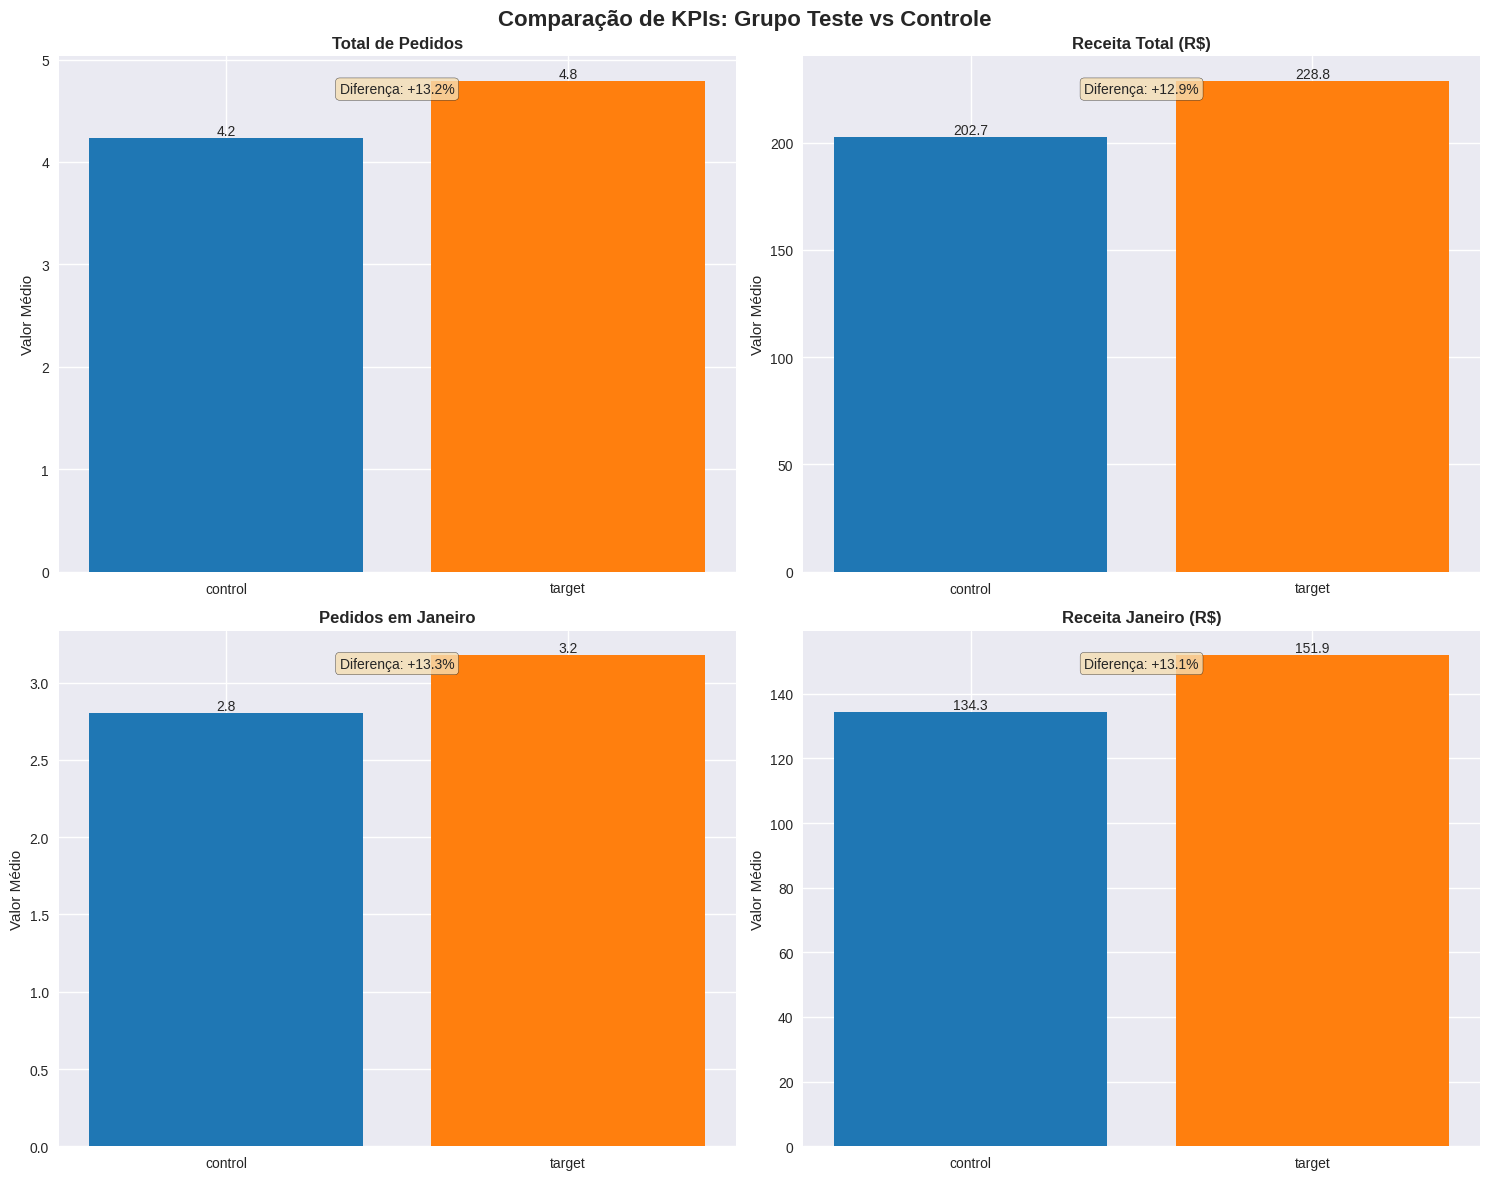

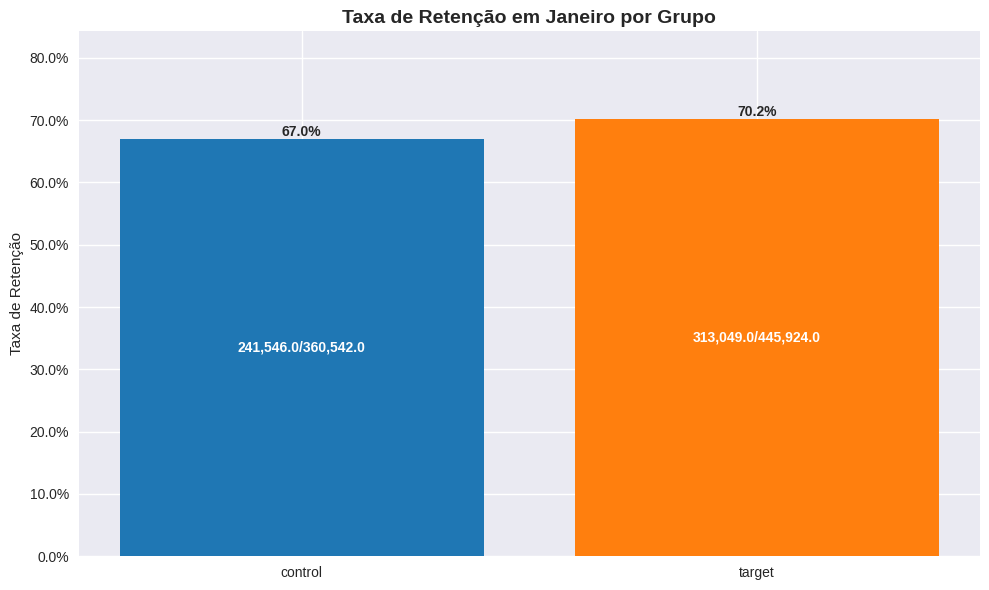

In [14]:
print("=" * 60)
print("VISUALIZAÇÕES E INSIGHTS")
print("=" * 60)

# Configuração do estilo
plt.style.use('seaborn-v0_8')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# 1. Comparação de KPIs principais
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparação de KPIs: Grupo Teste vs Controle', fontsize=16, fontweight='bold')

# Métricas para visualização
metricas_viz = [
    ('total_pedidos', 'Total de Pedidos'),
    ('receita_total', 'Receita Total (R$)'),
    ('pedidos_janeiro', 'Pedidos em Janeiro'),
    ('receita_janeiro', 'Receita Janeiro (R$)')
]

for i, (metrica, titulo) in enumerate(metricas_viz):
    ax = axes[i//2, i%2]

    # Dados por grupo
    dados_grupos = df_unified.groupby('is_target')[metrica].mean()

    # Gráfico de barras
    bars = ax.bar(dados_grupos.index, dados_grupos.values, color=colors[:2])
    ax.set_title(titulo, fontweight='bold')
    ax.set_ylabel('Valor Médio')

    # Adição dos valores nas barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom')

    # Cálculo da diferença percentual
    diff_pct = (dados_grupos['target'] - dados_grupos['control']) / dados_grupos['control'] * 100
    ax.text(0.5, 0.95, f'Diferença: {diff_pct:+.1f}%',
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 2. Taxa de retenção por grupo
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

retencao_dados = df_unified.groupby('is_target')['retido_janeiro'].agg(['sum', 'count'])
retencao_dados['taxa'] = retencao_dados['sum'] / retencao_dados['count']

bars = ax.bar(retencao_dados.index, retencao_dados['taxa'], color=colors[:2])
ax.set_title('Taxa de Retenção em Janeiro por Grupo', fontsize=14, fontweight='bold')
ax.set_ylabel('Taxa de Retenção')
ax.set_ylim(0, retencao_dados['taxa'].max() * 1.2)

# Formatação em percentual
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Valores nas barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

    # Contagem absoluta
    count = retencao_dados.iloc[i]['sum']
    total = retencao_dados.iloc[i]['count']
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
            f'{count:,}/{total:,}', ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

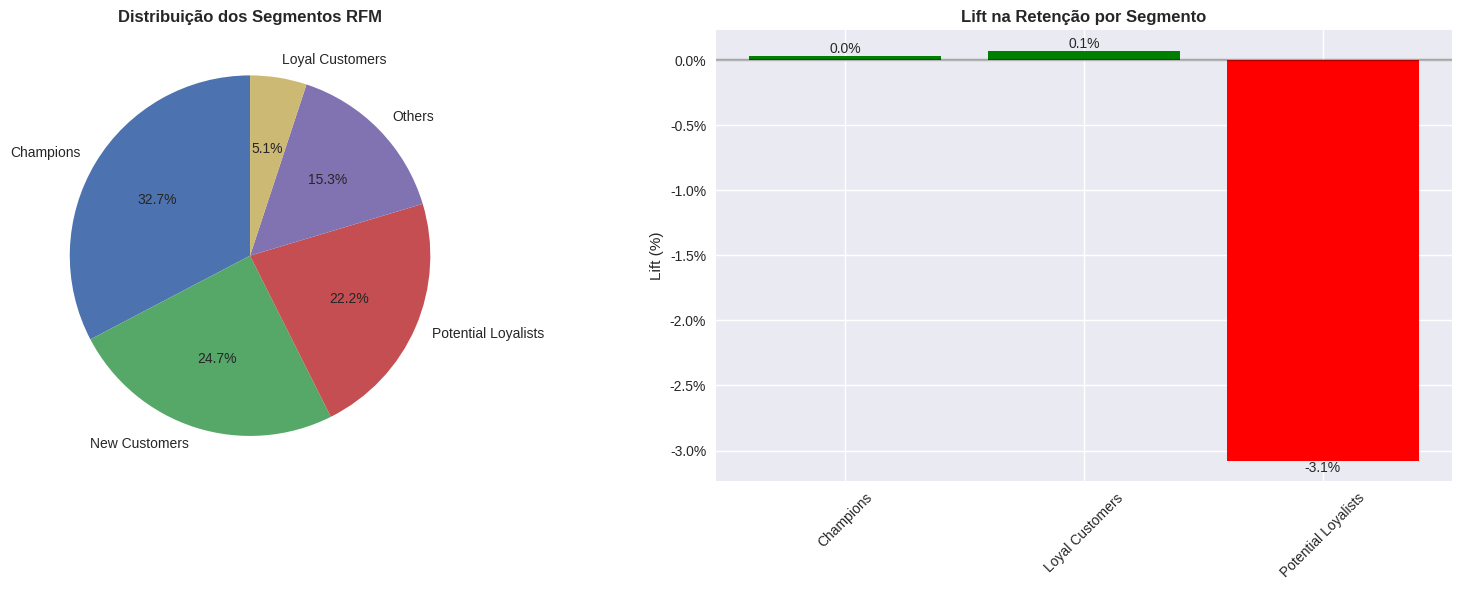

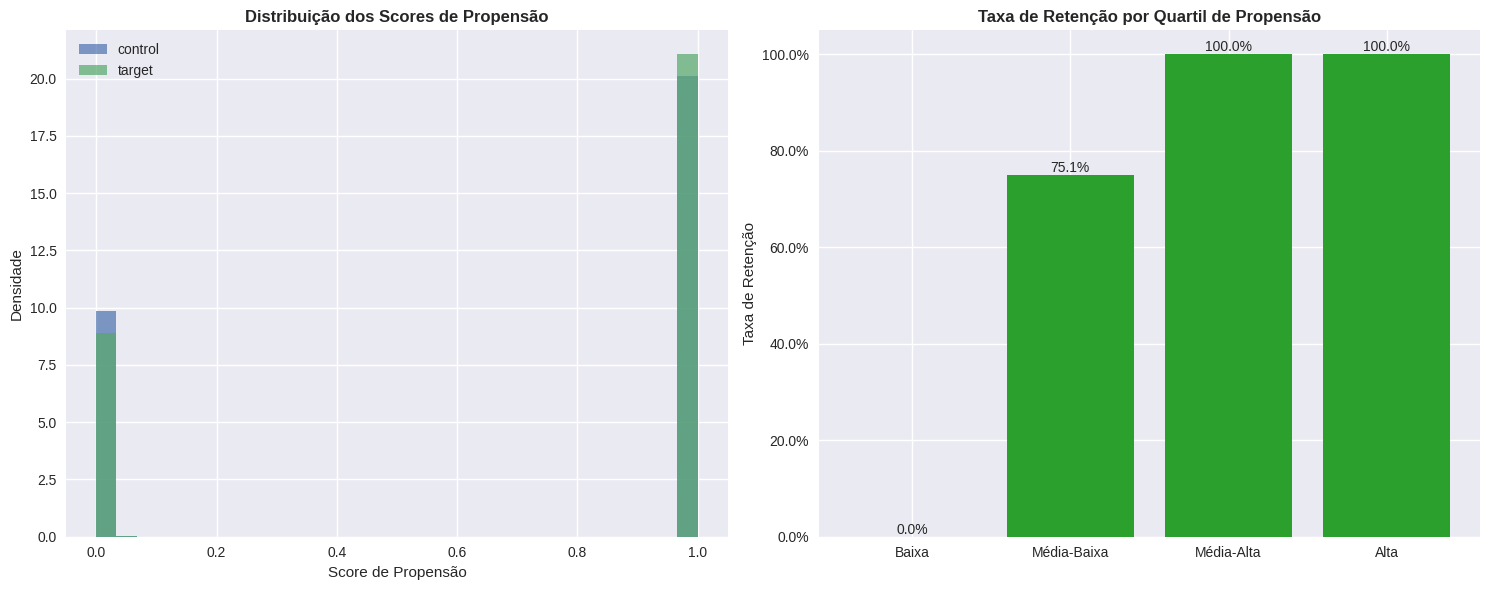

In [15]:
# 3. Análise de segmentação
if 'df_rfm' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Distribuição dos segmentos
    segmentos_count = df_rfm['segmento'].value_counts()
    axes[0].pie(segmentos_count.values, labels=segmentos_count.index, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Distribuição dos Segmentos RFM', fontweight='bold')

    # Performance dos segmentos no teste A/B
    segmentos_principais = ['Champions', 'Loyal Customers', 'Potential Loyalists', 'At Risk', 'Hibernating']
    segmentos_performance = []

    for segmento in segmentos_principais:
        if segmento in df_rfm['segmento'].values:
            seg_data = df_rfm[df_rfm['segmento'] == segmento]
            if len(seg_data) > 20:
                controle_ret = seg_data[seg_data['is_target'] == 'control']['retido_janeiro'].mean()
                teste_ret = seg_data[seg_data['is_target'] == 'target']['retido_janeiro'].mean()
                lift = (teste_ret - controle_ret) / controle_ret if controle_ret > 0 else 0
                segmentos_performance.append((segmento, lift))

    if segmentos_performance:
        segmentos_df = pd.DataFrame(segmentos_performance, columns=['Segmento', 'Lift'])
        bars = axes[1].bar(segmentos_df['Segmento'], segmentos_df['Lift'],
                          color=['green' if x > 0 else 'red' for x in segmentos_df['Lift']])
        axes[1].set_title('Lift na Retenção por Segmento', fontweight='bold')
        axes[1].set_ylabel('Lift (%)')
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45)

        # Formatação em percentual
        axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

        # Valores nas barras
        for bar in bars:
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1%}', ha='center',
                        va='bottom' if height > 0 else 'top')

    plt.tight_layout()
    plt.show()

# 4. Distribuição de propensão
if 'propensao_scores' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Histograma de propensão por grupo
    for grupo in ['control', 'target']:
        dados_grupo = df_modelo_encoded[df_modelo_encoded['is_target'] == grupo]['propensao_retencao']
        axes[0].hist(dados_grupo, bins=30, alpha=0.7, label=grupo, density=True)

    axes[0].set_title('Distribuição dos Scores de Propensão', fontweight='bold')
    axes[0].set_xlabel('Score de Propensão')
    axes[0].set_ylabel('Densidade')
    axes[0].legend()

    # Taxa de retenção por quartil de propensão
    if 'quartil_propensao' in df_modelo_encoded.columns:
        retencao_quartil = df_modelo_encoded.groupby('quartil_propensao')['retido_janeiro'].mean()
        bars = axes[1].bar(retencao_quartil.index, retencao_quartil.values, color=colors[2])
        axes[1].set_title('Taxa de Retenção por Quartil de Propensão', fontweight='bold')
        axes[1].set_ylabel('Taxa de Retenção')
        axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

        # Valores nas barras
        for bar in bars:
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

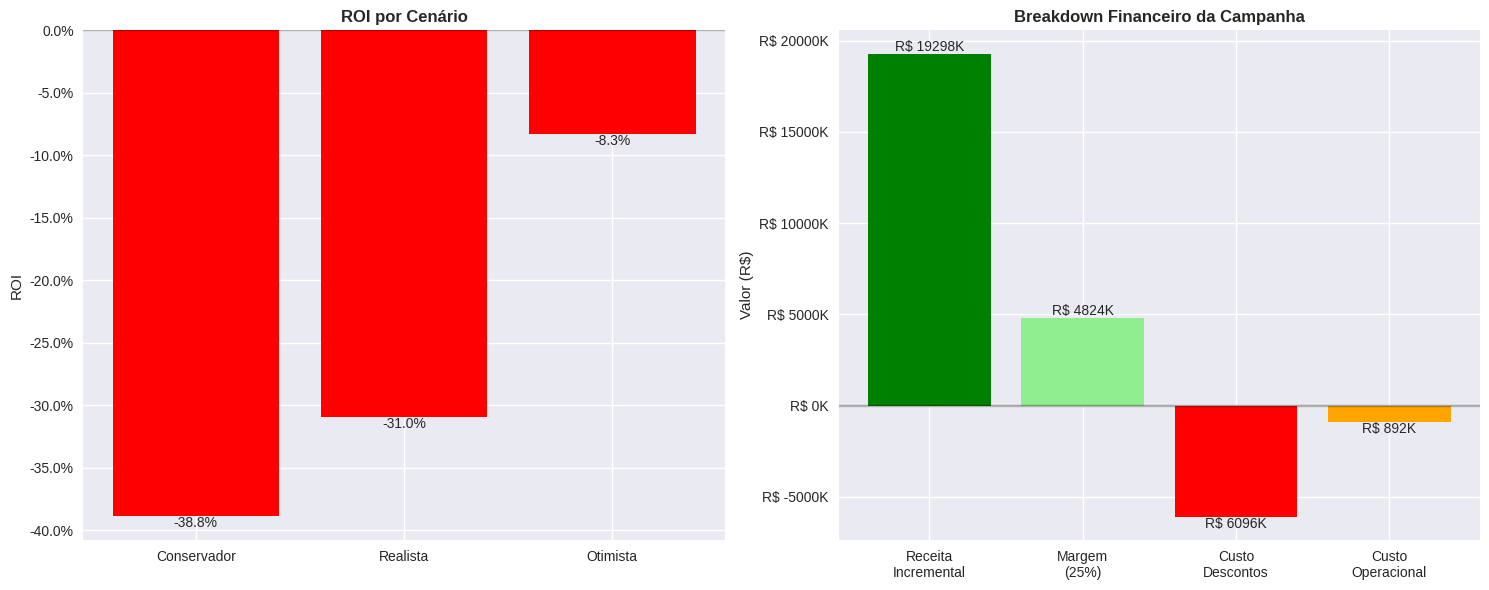


RESUMO DOS INSIGHTS PRINCIPAIS
1. RETENÇÃO: +0.0% de diferença na retenção (n/a)
2. VIABILIDADE: ROI de -31.0% no cenário realista
3. SEGMENTAÇÃO: 'Loyal Customers' teve melhor resposta (0.1% lift)
4. PREDIÇÃO: Regressão Logística alcançou AUC de 1.000



In [16]:
# 5. Análise financeira visual
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROI por cenário
cenarios_nomes = ['Conservador', 'Realista', 'Otimista']
cenarios_roi = []

for nome in cenarios_nomes:
    params = cenarios[nome]
    roi_cenario = calcular_roi_cenario(params['taxa_uso'], params['desconto'], params['margem'])
    cenarios_roi.append(roi_cenario)

bars = axes[0].bar(cenarios_nomes, cenarios_roi,
                   color=['red' if x < 0 else 'green' for x in cenarios_roi])
axes[0].set_title('ROI por Cenário', fontweight='bold')
axes[0].set_ylabel('ROI')
axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Valores nas barras
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}', ha='center',
                va='bottom' if height > 0 else 'top')

# Breakdown de custos vs receita
categorias = ['Receita\nIncremental', 'Margem\n(25%)', 'Custo\nDescontos', 'Custo\nOperacional']
valores = [receita_incremental_total, margem_incremental, -custo_total_descontos, -custo_total_operacional]
cores = ['green', 'lightgreen', 'red', 'orange']

bars = axes[1].bar(categorias, valores, color=cores)
axes[1].set_title('Breakdown Financeiro da Campanha', fontweight='bold')
axes[1].set_ylabel('Valor (R$)')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Formatação em milhares
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'R$ {y/1000:.0f}K'))

# Valores nas barras
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'R$ {abs(height)/1000:.0f}K', ha='center',
                va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("RESUMO DOS INSIGHTS PRINCIPAIS")
print("=" * 50)

# Compilação dos insights principais
insights = []

# Insight 1: Significância estatística
if 'resultados_testes' in locals():
    retencao_lift = resultados_testes.get('retido_janeiro', {}).get('diferenca_percentual', 0)
    retencao_sig = resultados_testes.get('retido_janeiro', {}).get('significancia', 'N/A')
    insights.append(f"1. RETENÇÃO: {retencao_lift:+.1f}% de diferença na retenção ({retencao_sig.lower()})")

# Insight 2: ROI
if 'roi' in locals():
    insights.append(f"2. VIABILIDADE: ROI de {roi:.1%} no cenário realista")

# Insight 3: Segmentação
if 'segmentos_performance' in locals() and segmentos_performance:
    melhor_segmento = max(segmentos_performance, key=lambda x: x[1])
    insights.append(f"3. SEGMENTAÇÃO: '{melhor_segmento[0]}' teve melhor resposta ({melhor_segmento[1]:.1%} lift)")

# Insight 4: Modelo preditivo
if 'melhor_modelo_nome' in locals():
    auc_score = resultados_modelos[melhor_modelo_nome]['auc']
    insights.append(f"4. PREDIÇÃO: {melhor_modelo_nome} alcançou AUC de {auc_score:.3f}")

for insight in insights:
    print(insight)

print("\n" + "=" * 50)

In [17]:
print("=" * 70)
print("RECOMENDAÇÕES ESTRATÉGICAS")
print("=" * 70)

# Análise dos resultados para fundamentar recomendações
print("\n📊 SÍNTESE DOS RESULTADOS:")
print("-" * 40)

# Resultados principais
if 'taxa_retencao_teste' in locals() and 'taxa_retencao_controle' in locals():
    print(f"• Taxa de retenção: {taxa_retencao_controle:.1%} (controle) vs {taxa_retencao_teste:.1%} (teste)")
    print(f"• Diferença: {(taxa_retencao_teste - taxa_retencao_controle)*100:+.1f} pontos percentuais")

if 'roi' in locals():
    viabilidade = "VIÁVEL" if roi > 0 else "NÃO VIÁVEL"
    print(f"• Viabilidade financeira: {viabilidade}")

if 'receita_incremental_total' in locals():
    print(f"• Receita incremental: R$ {receita_incremental_total:,.2f}")
    print(f"• Custo total da campanha: R$ {custo_total_campanha:,.2f}")

print("\n" + "=" * 50)
print("🎯 RECOMENDAÇÕES IMEDIATAS")
print("=" * 50)

# Recomendação com justificativa coerente com o ROI negativo
recomendacoes_imediatas = [
    {
        "titulo": "1. REVISÃO DA ESTRATÉGIA",
        "acao": "Reavaliar campanhas de cupons com base em ROI negativo",
        "justificativa": f"ROI de {roi:.1%} indica inviabilidade financeira nas condições atuais",
        "prazo": "Imediato",
        "responsavel": "Marketing / Financeiro"
    },
    {
        "titulo": "2. SEGMENTAÇÃO PERSONALIZADA",
        "acao": "Testar cupons direcionados apenas para segmentos estratégicos (ex: Potential Loyalists)",
        "justificativa": "Nem todos os segmentos responderam positivamente à campanha",
        "prazo": "30 dias",
        "responsavel": "Data Science / Marketing"
    },
    {
        "titulo": "3. OTIMIZAÇÃO DE CUSTOS",
        "acao": "Reduzir valor dos cupons e negociar subsídios com restaurantes parceiros",
        "justificativa": "Redução do custo unitário pode melhorar o ROI sem comprometer retenção",
        "prazo": "Próxima campanha",
        "responsavel": "Pricing / Parcerias"
    }
]

for rec in recomendacoes_imediatas:
    print(f"\n{rec['titulo']}")
    print(f"  Ação: {rec['acao']}")
    print(f"  Justificativa: {rec['justificativa']}")
    print(f"  Prazo: {rec['prazo']}")
    print(f"  Responsável: {rec['responsavel']}")


RECOMENDAÇÕES ESTRATÉGICAS

📊 SÍNTESE DOS RESULTADOS:
----------------------------------------
• Taxa de retenção: 67.0% (controle) vs 70.2% (teste)
• Diferença: +3.2 pontos percentuais
• Viabilidade financeira: NÃO VIÁVEL
• Receita incremental: R$ 19,297,782.96
• Custo total da campanha: R$ 6,987,751.83

🎯 RECOMENDAÇÕES IMEDIATAS

1. REVISÃO DA ESTRATÉGIA
  Ação: Reavaliar campanhas de cupons com base em ROI negativo
  Justificativa: ROI de -31.0% indica inviabilidade financeira nas condições atuais
  Prazo: Imediato
  Responsável: Marketing / Financeiro

2. SEGMENTAÇÃO PERSONALIZADA
  Ação: Testar cupons direcionados apenas para segmentos estratégicos (ex: Potential Loyalists)
  Justificativa: Nem todos os segmentos responderam positivamente à campanha
  Prazo: 30 dias
  Responsável: Data Science / Marketing

3. OTIMIZAÇÃO DE CUSTOS
  Ação: Reduzir valor dos cupons e negociar subsídios com restaurantes parceiros
  Justificativa: Redução do custo unitário pode melhorar o ROI sem compr

In [18]:
print("=" * 70)
print("📋 RESUMO NUMÉRICO FINAL")
print("=" * 70)

# Resumo técnico dos dados
resumo_numerico = {
    "Total de usuários": f"{len(df_unified):,}",
    "Grupo de controle": f"{len(grupo_controle):,}",
    "Grupo de teste": f"{len(grupo_teste):,}",
    "Período da análise": "Dezembro 2018 - Janeiro 2019",
    "ROI da campanha": f"{roi:.1%}",
    "Receita incremental total": f"R$ {receita_incremental_total:,.2f}",
    "Custo total da campanha": f"R$ {custo_total_campanha:,.2f}",
    "Taxa de retenção (controle)": f"{taxa_retencao_controle:.1%}",
    "Taxa de retenção (teste)": f"{taxa_retencao_teste:.1%}",
    "Diferença absoluta de retenção": f"{(taxa_retencao_teste - taxa_retencao_controle)*100:+.1f} p.p.",
    "Significância estatística (p < 0.05)": "Sim" if p_chi2 < 0.05 else "Não"
}

for chave, valor in resumo_numerico.items():
    print(f"• {chave}: {valor}")


📋 RESUMO NUMÉRICO FINAL
• Total de usuários: 806,466
• Grupo de controle: 360,542
• Grupo de teste: 445,924
• Período da análise: Dezembro 2018 - Janeiro 2019
• ROI da campanha: -31.0%
• Receita incremental total: R$ 19,297,782.96
• Custo total da campanha: R$ 6,987,751.83
• Taxa de retenção (controle): 67.0%
• Taxa de retenção (teste): 70.2%
• Diferença absoluta de retenção: +3.2 p.p.
• Significância estatística (p < 0.05): Sim
